In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

# 1. Import the train datasets

In [2]:
X_train = pd.read_csv("B_encoded_train_data.csv",index_col=0)
Y_train = pd.read_csv("A_Log_sales_train.csv",index_col=0)

In [3]:
Model_1 = LinearRegression()

# 2. Setup Pipeline

In [4]:
poly = PolynomialFeatures()
SLR = Model_1

In [5]:
# Step 1: Polynomial transform
# Step 2: PCA
# Step 3: Model
pipe = Pipeline(steps=[("poly",poly),("SLR",SLR)])

In [6]:
param_grid = {
    "poly__degree":[1,2]
}

# 3. Setup GridSearch

In [7]:
score_metric = 'neg_mean_squared_error'
search = GridSearchCV(pipe,param_grid,
                      n_jobs=-1,
                      cv=10,
                      scoring=score_metric)

In [8]:
search.fit(X_train,Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('SLR', LinearRegression())]),
             n_jobs=-1, param_grid={'poly__degree': [1, 2]},
             scoring='neg_mean_squared_error')

In [9]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=-0.757):
{'poly__degree': 1}


In [10]:
df = pd.DataFrame(search.cv_results_)
df = df.sort_values(by=['rank_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.080484,0.009995,0.010373,0.002283,1,{'poly__degree': 1},-0.507268,-0.553888,-2.282656,-0.617354,-0.685490,-0.547843,-0.565262,-0.561417,-0.642258,-0.610287,-0.757372,0.510814,1
1,47.713296,1.752018,0.112054,0.054249,2,{'poly__degree': 2},-2.887430,-2.637674,-100.149074,-3.135918,-3.602027,-4.364371,-2.661824,-3.289972,-2.830223,-2.808469,-12.836698,29.108395,2


# 4. Best Hyperparameter

In [11]:
parms = pd.DataFrame(df['params'])
for i in parms.iloc[0]:
    print(i)

{'poly__degree': 1}


# 5. Evaluate Model $log(Sales)$

In [12]:

best_degree=parms.iloc[0][0]['poly__degree']


In [13]:
Model_2 = LinearRegression()

In [14]:
poly1 = PolynomialFeatures(degree=best_degree)

In [15]:
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(X_train,Y_train,test_size=0.2,random_state=132)


In [16]:

SLR1 = Model_2
SLR1.fit(X_train1,Y_train1)

LinearRegression()

In [17]:
MSE(SLR1.predict(X_test1),Y_test1)

0.5559557459381865

In [18]:
result = pd.DataFrame(np.exp(Y_test1))

In [19]:
result["Predicted_sales"] = np.exp(SLR1.predict(X_test1))

In [20]:
MSE(result["sales"],result["Predicted_sales"])

523.7205218228457

# 5.1 Model using original sales data

In [21]:
Model_3 = LinearRegression()

In [22]:
OY_train = pd.read_csv("A_sales_train.csv",index_col=0)

In [23]:
X_train2,X_test2,Y_train2,Y_test2 = train_test_split(X_train,OY_train,test_size=0.2,random_state=132)

In [24]:

SLR2 = Model_3
SLR2.fit(X_train2,Y_train2)

LinearRegression()

In [25]:
MSE(SLR2.predict(X_test2),Y_test2)

487.94566514975935

#### Notably model trained on log(Sales) has lower out-of-sample MSE than model with unmodified Sales

# 6. Inventory Decision

In [26]:
residual = result['sales']-result['Predicted_sales']

In [27]:
Price=20
Cost=12
Salvage=8
Over=Cost - Salvage
Under=Price - Cost
Over, Under

(4, 8)

### QQ plot to explore the distribution of residual

#### Normal Distribution

In [28]:
import scipy.stats as sct

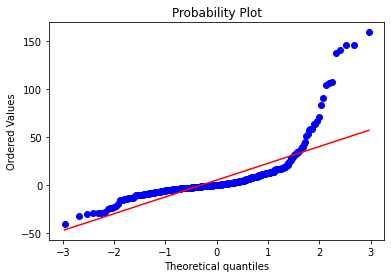

In [29]:
import scipy
scipy.stats.probplot(residual, dist="norm", plot=plt)
plt.show()

In [30]:
s = residual.std()
opt_dec_N=np.ceil(sct.norm.ppf(Under/(Under+Over))*s + result['Predicted_sales'])

#### Exponential Distribution

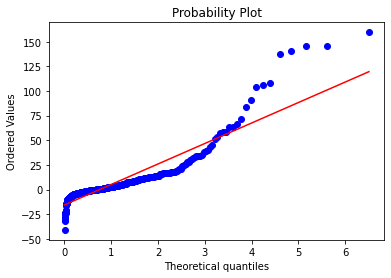

In [31]:
scipy.stats.probplot(residual, dist="expon", plot=plt)
plt.show()

In [32]:
opt_dec_E=np.ceil((-result['Predicted_sales'])*np.log(1-(Under/(Under+Over))))

#### Empirical Distribution

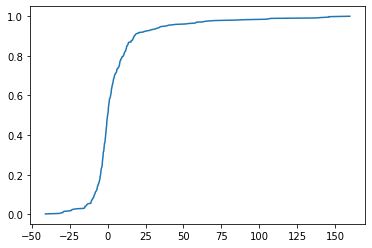

In [33]:
size = residual.shape[0]
step=1/size
jumps = [step*i for i in range(1,size+1)]
Sample = sorted(residual)
plt.plot(Sample,jumps)

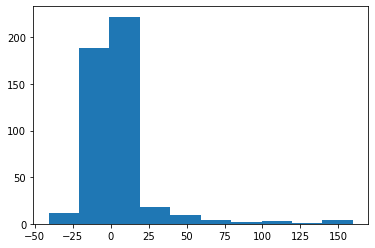

In [34]:
plt.hist(Sample)
plt.show()

In [35]:
def inv(sample,jump,area):
    size = len(sample)
    i=0
    temp=jump[i]
    while temp<area:
        i+=1
        temp=jump[i]
        
    return sample[i]

In [36]:
offset = inv(Sample,jumps,2/3)
offset

3.500774247698889

In [37]:
opt_dec_B = np.ceil(result['Predicted_sales']+offset)

# 7. Out-of-samples Profit

In [38]:
#max profit for test data set
max_profit = result['sales'].sum()*(Price-Cost)
max_profit

82096.0

In [39]:
def profit(demand,inv):
    return (Price-Salvage)*np.minimum(demand,inv)-(Cost-Salvage)*inv

In [40]:
#Profit (Normal)
profit_lst_N = profit(result['sales'],opt_dec_N)
profit_lst_N.sum()

45992.0

In [41]:
#Profit (Exponential)
profit_lst_E = profit(result['sales'],opt_dec_E)
profit_lst_E.sum()

48936.0

In [42]:
#Profit (Empirical)
profit_lst_B = profit(result['sales'],opt_dec_B)
profit_lst_B.sum()

48592.0

# 8. K-Fold Cross Validation

### Repeat steps 5,6,7 with 10-fold cross validation

In [43]:
Model_4=LinearRegression()

In [44]:
from sklearn.model_selection import KFold
k=10
kf = KFold(n_splits=k)
X_train_t=X_train.to_numpy()
Y_train_t=Y_train.to_numpy()
model = []
mse_lst = []
max_profit_lst = []
profit_N_lst = []
profit_E_lst = []
profit_B_lst = []

for train_index,test_index in kf.split(X_train_t):
    X_train_K,X_test_K=X_train_t[train_index],X_train_t[test_index]
    Y_train_K,Y_test_K=Y_train_t[train_index],Y_train_t[test_index]
    
    #PCA to transform train data
    
    #Model
    SLR_K = Model_4
    SLR_K.fit(X_train_K,Y_train_K)
    
    #pca to transform test data

    
    #MSE
    mse_lst.append(MSE(SLR_K.predict(X_test_K),Y_test_K))
    
    #Transform log(sale) back to sale
    result_K = pd.DataFrame(np.exp(Y_test_K))
    result_K["Predicted_sales"] = np.exp(SLR_K.predict(X_test_K))
    
    #Obtain residual
    residual_K = result_K[0]-result_K['Predicted_sales']
    
    #Get std for Normal distribution
    s_K = residual.std()
    
    #Inventory Decision (Normal)
    opt_dec_N_K=np.ceil(sct.norm.ppf(Under/(Under+Over))*s_K + result_K['Predicted_sales'])
    #Inventory Decision (Exponential)
    opt_dec_E_K=np.ceil((-result_K['Predicted_sales'])*np.log(1-(Under/(Under+Over))))
    
    #Inventory Decision (Empirical Distribution)
    size_K = residual_K.shape[0]
    step_K=1/size_K
    jumps_K = [step_K*i for i in range(1,size+1)]
    Sample_K = sorted(residual_K)
    offset_K = inv(Sample_K,jumps_K,2/3)
    opt_dec_B_K = np.ceil(result_K['Predicted_sales']+offset_K)
    
    #Out-of_sample profit
    profit_lst_B_K = profit(result_K[0],opt_dec_B_K)
    profit_B_lst.append(profit_lst_B_K.sum())
    
    profit_lst_N_K = profit(result_K[0],opt_dec_N_K)
    profit_N_lst.append(profit_lst_N_K.sum())
    
    profit_lst_E_K = profit(result_K[0],opt_dec_E_K)
    profit_E_lst.append(profit_lst_E_K.sum())
    
    max_profit_K = result_K[0].sum()*(Price-Cost)
    max_profit_lst.append(max_profit_K)
    
max_profit_lst = np.array(max_profit_lst)
profit_N_lst = np.array(profit_N_lst)
profit_E_lst = np.array(profit_E_lst)
profit_B_lst = np.array(profit_B_lst)

fraction_of_max_N = profit_N_lst/max_profit_lst
fraction_of_max_E = profit_E_lst/max_profit_lst
fraction_of_max_B = profit_B_lst/max_profit_lst

dist_profit = ["Normal","Exponential","Empirical","Max"]
dist_frac = ["Normal","Exponential","Empirical"]
col_name = ["Dataset_"+str(i) for i in range(1,k+1)]

profit_lst = [profit_N_lst,profit_E_lst,profit_B_lst,max_profit_lst]
profit_table = pd.DataFrame(profit_lst,index=dist_profit,columns=col_name)
profit_table["mean_profit"]=profit_table.mean(axis=1)
profit_table["std_profit"]=profit_table.std(ddof=1,axis=1)

fraction_lst = [fraction_of_max_N,fraction_of_max_E,fraction_of_max_B]
fraction_table = pd.DataFrame(fraction_lst,index=dist_frac,columns=col_name)
fraction_table["mean_fraction"]=fraction_table.mean(axis=1)

In [45]:
fraction_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5,Dataset_6,Dataset_7,Dataset_8,Dataset_9,Dataset_10,mean_fraction
Normal,0.600039,0.625420,-1.048390e+07,0.612790,0.561080,0.572424,-0.250613,0.607285,0.546797,0.571456,-1.048389e+06
Exponential,0.623719,0.633109,-1.151774e+07,0.641888,0.569138,0.600799,-0.319801,0.619341,0.570956,0.597580,-1.151773e+06
Empirical,0.626136,0.640887,-1.048390e+07,0.629614,0.583562,0.604999,-0.223820,0.623244,0.570061,0.599116,-1.048389e+06


In [46]:
profit_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5,Dataset_6,Dataset_7,Dataset_8,Dataset_9,Dataset_10,mean_profit,std_profit
Normal,24832.0,28304.0,-4.853625e+11,28556.0,27852.0,22352.0,-12272.0,28008.0,24444.0,23800.0,-4.853623e+10,1.456087e+11
Exponential,25812.0,28652.0,-5.332252e+11,29912.0,28252.0,23460.0,-15660.0,28564.0,25524.0,24888.0,-5.332250e+10,1.599676e+11
Empirical,25912.0,29004.0,-4.853625e+11,29340.0,28968.0,23624.0,-10960.0,28744.0,25484.0,24952.0,-4.853623e+10,1.456087e+11
Max,41384.0,45256.0,4.629600e+04,46600.0,49640.0,39048.0,48968.0,46120.0,44704.0,41648.0,4.496640e+04,3.203875e+03


In [47]:
profit_table.to_csv(".\\Model_Selection_Result\\2.2B_Poly_reg(No PCA).csv")